# Forecasting PM2.5

### Objective 

Once the data has been properly cleaned, a specific pollutant can be selected to forecast using a ML model. 

PM2.5 will be selected given that it's the pollutant with the most complete information and also it has great relevance as a main pollutant in Tlaquepaque.

Reframing the dataset involves reformating the information for supervised learning, i.e., a set of variables will be used as dependent variables (to give context) and they will each have an independent variable (result) assigned to them. For time series forecasting, it's important to also group these dependent and independent variables in windows of time. 

This allows the model to generalize the information of time (t-1) and use it to predict the results of time (t).

In [9]:
from math import sqrt
import numpy as np # Numerical operations

import pandas as pd # Dataset manipulation

import seaborn as sns # Graphs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM # Model
from tensorflow.keras.layers import Dense, Dropout # Layer
from tensorflow.keras.optimizers import Adam # Optimizer function
from sklearn.preprocessing import MinMaxScaler # Scale data

from sklearn.metrics import mean_squared_error # Performance metrics
from sklearn.metrics import r2_score

from optimizer import MLPOptimizer # Hyperparameter optimization

import joblib # Save model

import warnings ## Suppressing unnecessary warnings
warnings.filterwarnings("ignore")

## Part 1: Reframe the dataset

### Select pollutant to predict and exogenous variables

To forecast PM2.5, the features used will be:

_Exogenous variables (dependent variable):_

- Temperature (TMP)
- Relative Humidity (RH)
- Barometric Pressure (PBA)
- Wind Speed (WS)
- Wind Direction (WD)

_Pollutant (independent variable):_

- Fine Particulate Matter less than 2.5 micrometers (PM2.5)

This requires a multivariate model, which in this case will be LTSM.

In [3]:
# Create a dataframe with specified features
def select_df_features(df:pd.DataFrame, features:list)->pd.DataFrame:
    df_select = pd.DataFrame()
    for feature in features:
        df_select[feature] = df[feature]
    return df_select

### Normalize data

Once the data is separated, the data will be transformed to a common scale to improve the model's performance (scaling). 
Normalizing the data allows each feature to have values between a certain range, and depending on the activation functions the model uses, it could improve performance.

In this case, the data held for each feature will be scaled to have values between 0 and 1.

In [4]:
def normalize_data(df:pd.DataFrame)->tuple:
    # Create a data scaler
    data_scaler = MinMaxScaler(feature_range=(0,1))

    # Scale the information in each column
    data_norm = data_scaler.fit_transform(df.values)
    
    return data_norm, data_scaler

### Timeseries to supervised learning

Supervised learning involves training and evaluating a model with information that is already has the correct result specified.

For the existing dataset, the dataset needs to be separated in instances of the five dependent features labeled with the correct result, which is the PM2.5 reading for a given day. This is already done.

Since this is also a time series forecasting problem, the data needs to be further split into windows of time. This means creating two overlapping groups of n and m instances, where:

- Group one has n past instances of the all variables to learn from
- Group two has m future instances of the desired variable to forecast (PM2.5)

These groups overlap because the first group has observations from [0,n],[1,n+1] and so on, the same happens for group 2.

This allows the model to learn how PM2.5 will change given certain circumstances, as well as use previously learned predictions to make new ones.


In [5]:
# Separate the data into two groups of windows of n instances 
def series_to_supervised(data:np.ndarray, column_names:list, 
                         n_dependent:int=1, n_pred:int=1, 
                         dropnan=True)->pd.DataFrame:
    
    # Obtain number of variables in data
    n_vars = 1 if type(data) is list else data.shape[1]
    
    # Create a dataframe of the data
    df = pd.DataFrame(data)
    
    # Save shifted columns and their names
    cols, names = list(), list()
    
    # Create the input sequence (t-n, ... t-1) number of past instances
    for i in range(n_dependent, 0, -1):
        # Shift all data in features i positions downwards
        cols.append(df.shift(i))
        
        # Save the name of the column and how many positions it was shifted
        names += [(f"{column_names[j]}(t-{i})") for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n) number of predictions
    for i in range(0, n_pred):
        # Shift all features i positions upwards
        cols.append(df.shift(-i))
        
        # Save the name of the colum  and the times it was shifted
        if i == 0:
            names += [(f"{column_names[j]}(t)") for j in range(n_vars)]
        else:
            names += [(f"{column_names[j]}(t+{i})") for j in range(n_vars)]
    
    # Join the resulting columns and give them column names
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

Only the feature to be forecasted should be kept in the future timesteps groups (from time t forward). In other words, all features that aren't the independent one (pm25) will be dropped for time t onwards.

In [6]:
def remove_extra_timesteps(df:pd.DataFrame, n_features:int, 
                          n_dependent:int, n_steps:int, 
                          target_feature_idx:int)->pd.DataFrame:
    # Start index of future timesteps
    start_pred = n_features * n_dependent

    # End index of future timesteps
    end_pred = start_pred + (n_features * n_steps)

    columns_to_drop = [
        i for i in range(start_pred, end_pred) 
        if i % n_features != target_feature_idx
        ]
    
    # Drop columns we don't want to predict 
    df = df.drop(df.columns[columns_to_drop], axis=1)
    
    return df

## Part 2: Divide dataset into training, validation and test sets

The machine learning model needs to be trained on different sets of the data so that it doesn't become used to only one kind of data. The dataset used has 3 years worth of information.

In [7]:
# Divide the dataset in train, validation and test set
def divide_series(df: pd.DataFrame, train:float=0.65, val:float=0.15):
    data_len = len(df)
    train_size = int(data_len * train)
    val_size = int(data_len * val)
    
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for feature in df.columns:
        train_df[feature] = df[feature][:train_size]
        val_df[feature] = df[feature][train_size:train_size + val_size]
        test_df[feature] = df[feature][train_size + val_size:]
    
    return train_df, val_df, test_df

### Split the data into X and y sets and reshape for model

Once the data has been separated into these sets, they need to be further separated into X and y sets, which only means separating the dependent variables (not PM2.5) from the independent variables (PM2.5). Or in the time series case, windows of past n observations from m future observations.

The majority of M.L. models requiere the X set to be reshaped in the following format [n_instances, n_timesteps, n_features]

In [15]:
def create_X_y_sets(n_steps:int, n_dependent:int, train_df:pd.DataFrame, 
                    val_df:pd.DataFrame, test_df:pd.DataFrame)->tuple:
    # Obtain the values for each set of data
    train_values = train_df.values
    val_values = val_df.values
    test_values = test_df.values
    
    # X set has past timesteps, y only has last n_step features
    train_X, train_y = train_values[:,:-n_steps], train_values[:,-n_steps:]
    val_X, val_y = val_values[:,:-n_steps], val_values[:,-n_steps:]
    test_X, test_y = test_values[:,:-n_steps], test_values[:,-n_steps:]
    
    # Reshape each set
    train_X = train_X.reshape(train_X.shape[0], n_dependent, n_features)
    val_X = val_X.reshape(val_X.shape[0], n_dependent, n_features)
    test_X = test_X.reshape(test_X.shape[0], n_dependent, n_features)
    
    return train_X, train_y, val_X, val_y, test_X, test_y

## Part 3: Read dataset

In [10]:
filename = "semadet-aire-final"
filepath = f"datasets/feature_eng/{filename}.csv"

# Read dataset
df = pd.read_csv(filepath, parse_dates=[0], index_col=0)

In [11]:
# Dependent variables
features = ["pm25", "tmp", "rh", "ws", "wd"]
n_features = len(features)

# Independent variable
pollutant = "pm25"
pollutant_idx = 0

In [12]:
# Create dataframe
df_select = select_df_features(df, features)

# Sort dates 
df_select.sort_index(ascending=True, inplace=True)

# Observe first three instances
df_select.head(3)

,pm25,tmp,rh,ws,wd
date,,,,,
2017-01-01,24.869231,19.475000,52.125000,2.516667,9.648721
2017-01-02,24.869231,19.358333,49.691667,1.291667,9.957045
2017-01-03,24.869231,19.970833,43.037500,1.062500,11.695896


In [13]:
# Scale data between 0 and 1
data_norm, data_scaler = normalize_data(df_select)

## Part 4: One step forecasting

The first model will predict PM2.5 one day in advance based on six past days. 

In [58]:
# Amount of timesteps to forecast
n_steps = 1
# Amount of past timesteps to use
n_dependent = 6

In [59]:
# Reframe dataset
data_one_step = series_to_supervised(data_norm,
                                     features,
                                     n_dependent=n_dependent,
                                     n_pred=n_steps)

In [60]:
# Delete non independent variables from future timesteps
data_one_step = remove_extra_timesteps(data_one_step, 
                                       n_features,
                                       n_dependent,
                                       n_steps,
                                       pollutant_idx)

In [61]:
data_one_step.head(3)

,pm25(t-6),tmp(t-6),rh(t-6),ws(t-6),wd(t-6),pm25(t-5),tmp(t-5),rh(t-5),ws(t-5),wd(t-5),...,tmp(t-2),rh(t-2),ws(t-2),wd(t-2),pm25(t-1),tmp(t-1),rh(t-1),ws(t-1),wd(t-1),pm25(t)
6,0.2214,0.432335,0.549976,0.431929,0.027182,0.2214,0.425177,0.516898,0.218434,0.028059,...,0.579345,0.269721,0.407239,0.041083,0.2214,0.521308,0.284504,0.282337,0.036391,0.2214
7,0.2214,0.425177,0.516898,0.218434,0.028059,0.2214,0.462760,0.426444,0.178494,0.033000,...,0.521308,0.284504,0.282337,0.036391,0.2214,0.484236,0.303648,0.224969,0.034481,0.2214
8,0.2214,0.462760,0.426444,0.178494,0.033000,0.2214,0.502644,0.360968,0.201732,0.036100,...,0.484236,0.303648,0.224969,0.034481,0.2214,0.325210,0.398237,0.600402,0.024726,0.2214


In [62]:
# Obtain train, validation and test sets
train_df, val_df, test_df = divide_series(data_one_step, train=0.56, val=0.10)

In [63]:
print(f"Train set len: {len(train_df)}")
print(f"Validation set len: {len(val_df)}")
print(f"Test set len: {len(test_df)}")

Train set len: 610
Validation set len: 109
Test set len: 371


In [64]:
# Obtain train, validation and test sets
train_X, train_y, val_X, val_y, test_X, test_y = create_X_y_sets(n_steps,
                                                                 n_dependent,
                                                                 train_df,
                                                                 val_df,
                                                                 test_df)

In [65]:
print(f"Shape of train X for model: {train_X.shape}")
print(f"Shape of train y for model: {train_y.shape}")

print(f"Shape of val X for model: {val_X.shape}")
print(f"Shape of val y for model: {val_y.shape}")

print(f"Shape of test X for model: {test_X.shape}")
print(f"Shape of test y for model: {test_y.shape}")

Shape of train X for model: (610, 6, 5)
Shape of train y for model: (610, 1)
Shape of val X for model: (109, 6, 5)
Shape of val y for model: (109, 1)
Shape of test X for model: (371, 6, 5)
Shape of test y for model: (371, 1)


### Search for optimal hyperparameters

Optuna is a hyperparameter tuning framework that allows the user to select various hyperparameter options for a model and evaluates the performance of each during a set amount of trials.

In [66]:
mlp_optimizer = MLPOptimizer(n_steps, n_trials=100, output_nodes=n_steps)
study = mlp_optimizer.optimize(train_X, train_y, val_X, val_y)

[I 2025-05-05 21:53:08,186] A new study created in memory with name: no-name-3ac214e6-3d29-455f-865d-c5398a20068b
[I 2025-05-05 21:53:16,690] Trial 0 finished with value: 0.015814045444130898 and parameters: {'neurons': 100, 'epochs': 100, 'batch_size': 10}. Best is trial 0 with value: 0.015814045444130898.
[I 2025-05-05 21:53:24,637] Trial 1 finished with value: 0.006490044761449099 and parameters: {'neurons': 100, 'epochs': 200, 'batch_size': 100}. Best is trial 1 with value: 0.006490044761449099.
[I 2025-05-05 21:53:25,933] Trial 2 finished with value: 0.009542685933411121 and parameters: {'neurons': 10, 'epochs': 30, 'batch_size': 100}. Best is trial 1 with value: 0.006490044761449099.
[I 2025-05-05 21:53:35,130] Trial 3 finished with value: 0.007533877622336149 and parameters: {'neurons': 100, 'epochs': 200, 'batch_size': 72}. Best is trial 1 with value: 0.006490044761449099.
[I 2025-05-05 21:53:45,447] Trial 4 finished with value: 0.015587549656629562 and parameters: {'neurons': 

Best hyperparameters: {'neurons': 10, 'epochs': 50, 'batch_size': 10}


### Create model

The first layer in the network must define the number of inputs to expect. Input must be three-dimensional, comprised of samples, timesteps, and features.

In [ ]:
# Create model
model = Sequential()

# Input layer
model.add(LSTM(50, 
               input_shape=(train_X.shape[1], train_X.shape[2]),
               activation="relu"))

# Output layer
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(0.001))

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=100, 
    batch_size=72, 
    verbose=0,
    validation_data=(val_X, val_y),
    shuffle=False,
    )

In [19]:
def plot_training_history(history, filename:str, save:bool=True):
    # plot history
    plt.figure(figsize=(10, 5))
    plt.title(f"Training and validation loss per epoch for {n_steps} steps")
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    if save:
        plt.savefig(f"graphs/ltsm/{filename}")
    plt.show()

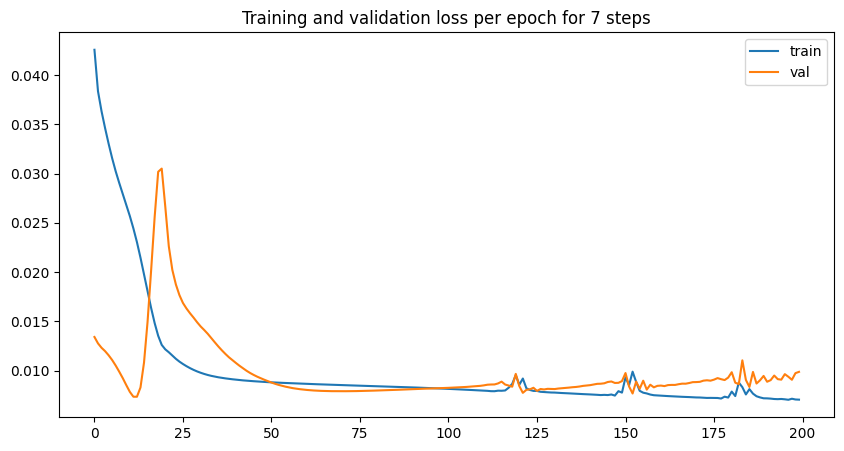

In [119]:
# Plot one step trainig history
filename = "one_step_training_val_loss.png"
plot_training_history(history, filename)

### Predict values and evaluate performance

In [94]:
# make a prediction
yhat = model.predict(test_X)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Once the pollutant values have been predicted, the scaling needs to be inverted to see what values have been predicted. In order to do this, the scaler needs to recieve an array of the same shape as the original dataframe. A dummy array can be created with zeroes placed in all the columns that aren't the independent variable to give as parameter to the `inverse_transform` function.

In [20]:
def inverse_scale(values:np.array, feature_idx:int, n_steps:int, n_samples:int, 
                  data_scaler)->np.array:
    # Placeholder for full features needed by scaler
    dummy = np.zeros((n_samples * n_steps, n_features))

    # Flatten yhat to 1D, and place it into dummy
    dummy[:, feature_idx] = values.reshape(-1)

    # Inverse transform
    inv_feat = data_scaler.inverse_transform(dummy)

    # Extract only the feature from the result
    inv_feat = inv_feat[:, feature_idx].reshape(test_y.shape)
    
    return inv_feat

In [ ]:
# Amount of instances in test set
n_samples = test_y.shape[0]

# Inverse scale for predicted and actual values
inv_yhat = inverse_scale(yhat, pollutant_idx, n_steps, n_samples, data_scaler)
inv_y = inverse_scale(test_y, pollutant_idx, n_steps, n_samples, data_scaler)

In [24]:
def rmse(predicted:np.array, actual:np.array)->None:
    for i in range(n_steps):
        step_rmse = np.sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
        print(f"Step t+{i+1} RMSE: {step_rmse:.3f}")

In [98]:
# RMSE for each timestep
rmse(inv_yhat, inv_y)

Step t+1 RMSE: 9.559


In [21]:
def plot_predicted_actual(predicted:np.array, actual:np.array, n_steps:int,
                          title:list[str], filename:list[str], 
                          save:bool=True)->None:
    actual_color = 'gray'    # pastel red
    predicted_color = 'blue' # pastel blue

    for step in range(n_steps):
        plt.figure(figsize=(10,5))
        
        plt.plot(np.arange(len(predicted[:, step])), actual[:, step], 
                linestyle='-', color=actual_color, label=f'Actual t+{step}')
        
        plt.plot(np.arange(len(predicted[:, step])), predicted[:, step], 
                linestyle='-', color=predicted_color, label=f'Predicted t+{step}')
        
        plt.title(title[step])
        plt.xlabel('Forecast Sample Index')
        plt.ylabel('PM2.5')
        plt.legend()
        plt.tight_layout()
        if save:
            plt.savefig(f"graphs/ltsm/{filename[step]}")
        plt.show()

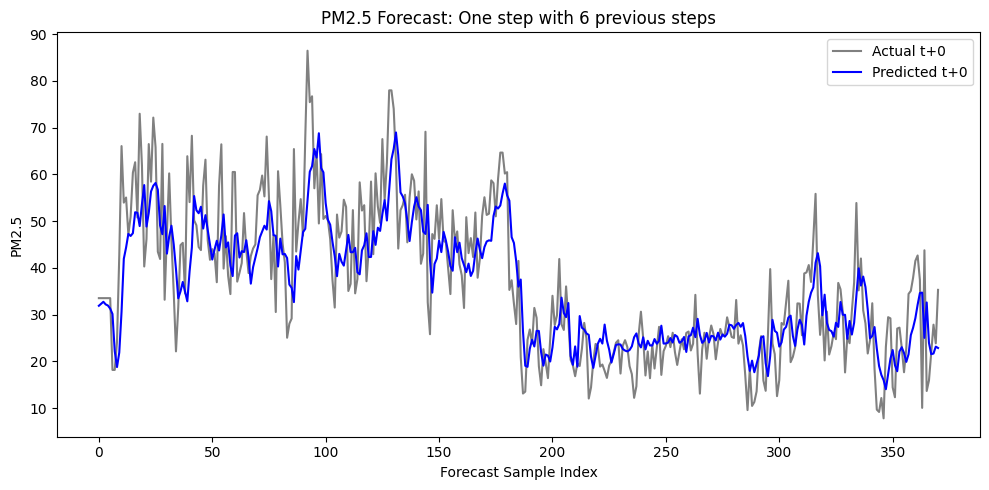

In [ ]:
titles = ["PM2.5 Forecast: One step with 6 previous steps"]
filenames = ["one_step_pred.png"]
plot_predicted_actual(inv_yhat, inv_y, n_steps, titles, filenames)

### Save the model

Once the model has reached an acceptable performance, it can be saved to a file in order to be used in the future.

In [103]:
def save_model(filename:str)->None:
    # Save the model as a pickle in a file 
    joblib.dump(model, filename) 

In [104]:
filename = "lstm_one_step.pkl"
save_model(filename)

## Step 5: Seven step forecast

### Reframe and divide data

In [16]:
# Amount of timesteps to forecast
n_steps = 7
# Amount of past timesteps to use
n_dependent = 23

# Reframe dataset
data_one_step = series_to_supervised(data_norm,
                                     features,
                                     n_dependent=n_dependent,
                                     n_pred=n_steps)

# Delete non independent variables from future timesteps
data_one_step = remove_extra_timesteps(data_one_step, 
                                       n_features,
                                       n_dependent,
                                       n_steps,
                                       pollutant_idx)

# Obtain train, validation and test sets
train_df, val_df, test_df = divide_series(data_one_step, train=0.56, val=0.10)

# Obtain train, validation and test sets
train_X, train_y, val_X, val_y, test_X, test_y = create_X_y_sets(n_steps,
                                                                 n_dependent,
                                                                 train_df,
                                                                 val_df,
                                                                 test_df)


### Search for optimal hyperparameters

In [235]:
mlp_optimizer = MLPOptimizer(n_steps, n_trials=100, output_nodes=n_steps)
study = mlp_optimizer.optimize(train_X, train_y, val_X, val_y)

[I 2025-05-06 01:55:06,097] A new study created in memory with name: no-name-db6fd552-5aed-448a-aa1f-6126888fb0b1
[I 2025-05-06 01:55:15,522] Trial 0 finished with value: 0.018913693726062775 and parameters: {'neurons': 100, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.018913693726062775.
[I 2025-05-06 01:55:28,507] Trial 1 finished with value: 0.0177101232111454 and parameters: {'neurons': 50, 'epochs': 100, 'batch_size': 10}. Best is trial 1 with value: 0.0177101232111454.
[I 2025-05-06 01:55:37,814] Trial 2 finished with value: 0.01592635177075863 and parameters: {'neurons': 100, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.01592635177075863.
[I 2025-05-06 01:55:51,453] Trial 3 finished with value: 0.013906699605286121 and parameters: {'neurons': 100, 'epochs': 200, 'batch_size': 72}. Best is trial 3 with value: 0.013906699605286121.
[I 2025-05-06 01:55:55,229] Trial 4 finished with value: 0.011891988106071949 and parameters: {'neurons': 100, 'e

Best hyperparameters: {'neurons': 10, 'epochs': 200, 'batch_size': 100}


### Create model

In [28]:
# Create model
model_seven = Sequential()

# Input layer
model_seven.add(LSTM(8, 
               input_shape=(train_X.shape[1], train_X.shape[2]),
               activation="relu"))

# Output layer
model_seven.add(Dense(7))

model_seven.compile(loss='mse', optimizer=Adam(0.001))

# fit network
history_seven = model_seven.fit(
    train_X, 
    train_y, 
    epochs=100, 
    batch_size=10, 
    verbose=0,
    validation_data=(val_X, val_y),
    shuffle=False,
    )

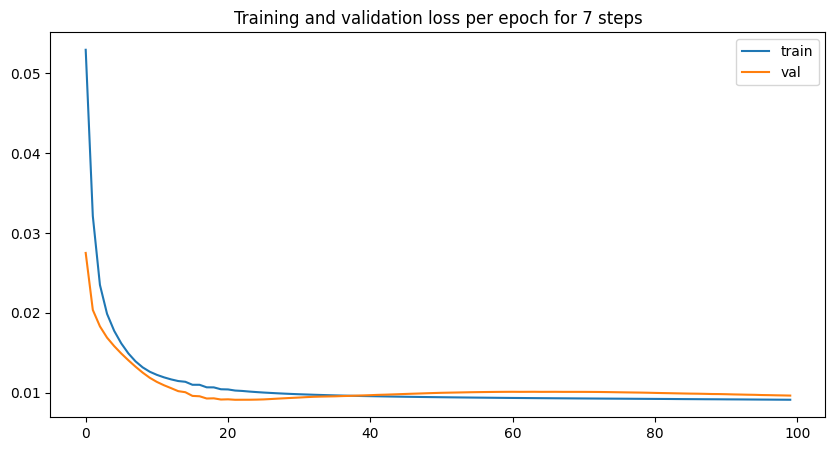

In [29]:
# Plot one step trainig history
filename = "seven_steps_training_val_loss.png"
plot_training_history(history_seven, filename, save=False)

### Predict values and evaluate performance

In [30]:
# make a prediction
yhat_seven = model_seven.predict(test_X)

# Amount of instances in test set
n_samples_seven = test_y.shape[0]

# Inverse scale for predicted and actual values
inv_yhat_seven = inverse_scale(yhat_seven, 
                               pollutant_idx, 
                               n_steps,
                               n_samples_seven, 
                               data_scaler)

inv_y_seven = inverse_scale(test_y, 
                            pollutant_idx, 
                            n_steps,
                            n_samples_seven, 
                            data_scaler)

# RMSE for each timestep
rmse(inv_yhat_seven, inv_y_seven)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Step t+1 RMSE: 9.438
Step t+2 RMSE: 11.218
Step t+3 RMSE: 12.714
Step t+4 RMSE: 13.338
Step t+5 RMSE: 15.754
Step t+6 RMSE: 12.761
Step t+7 RMSE: 13.160


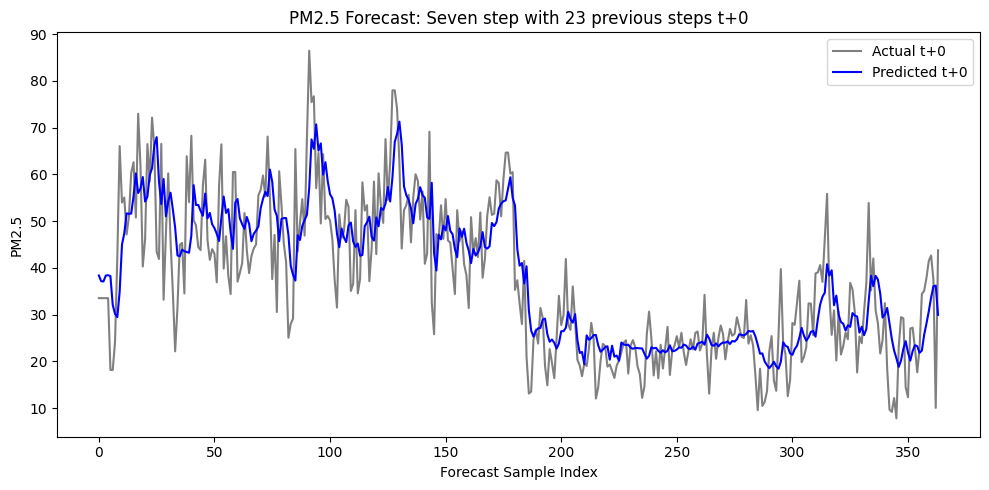

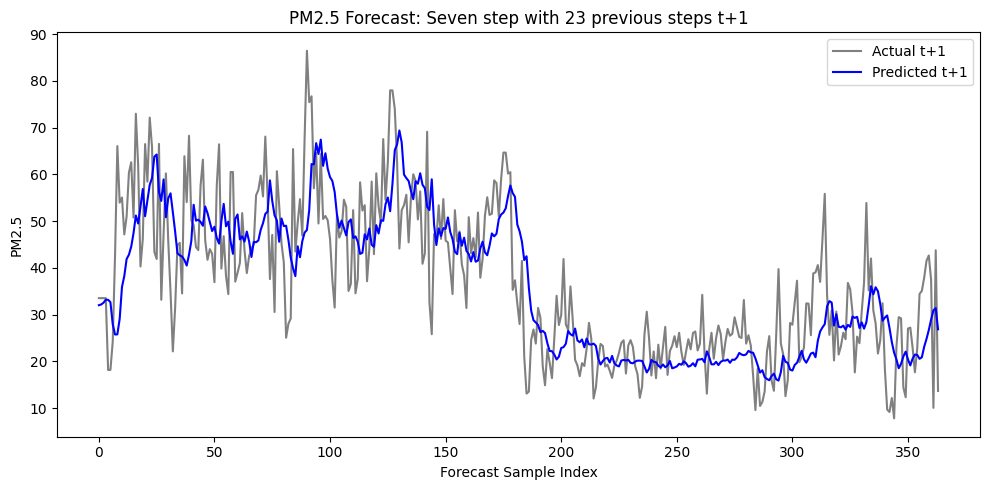

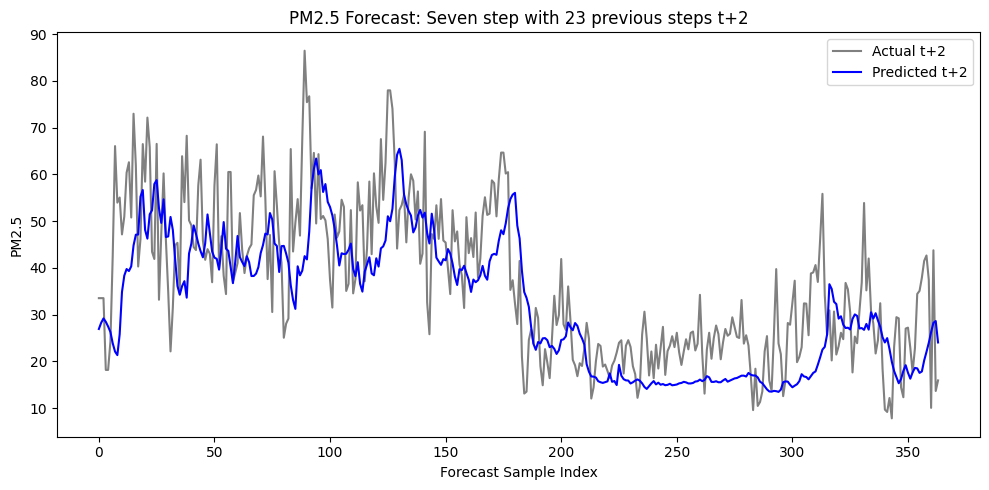

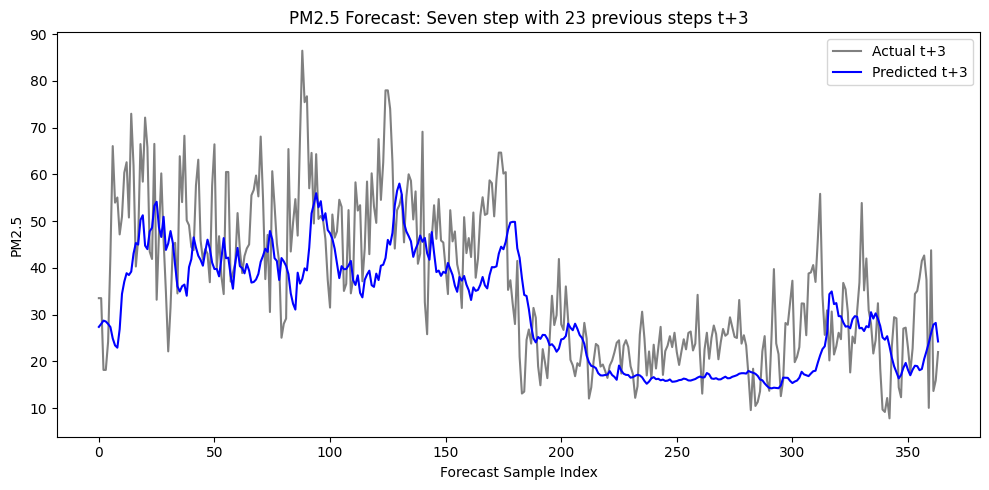

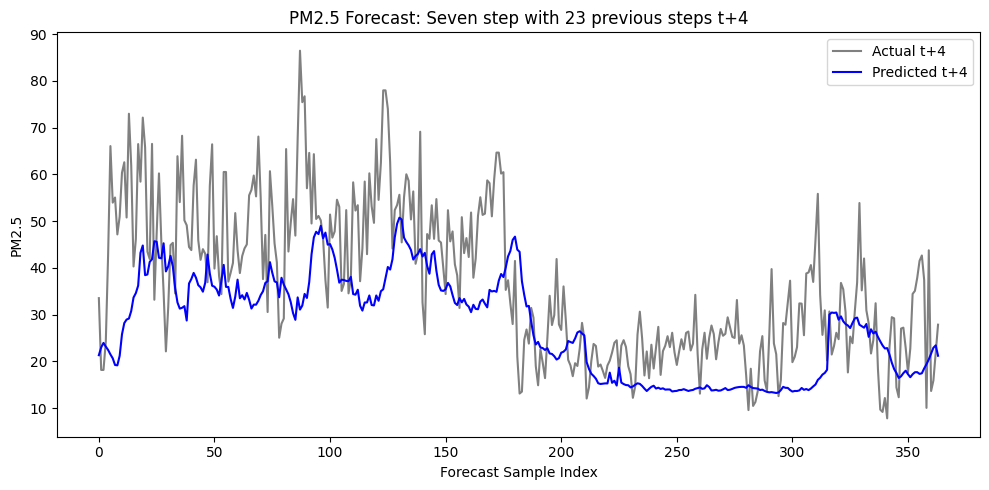

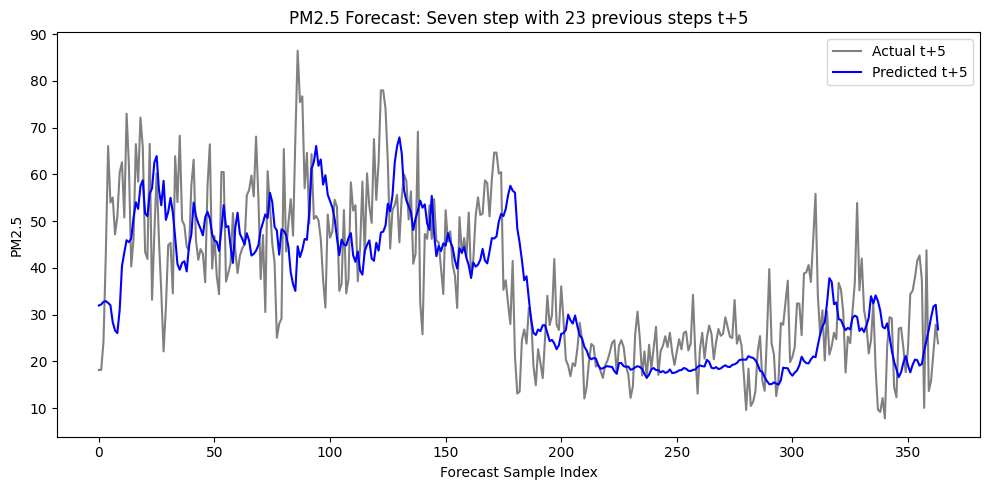

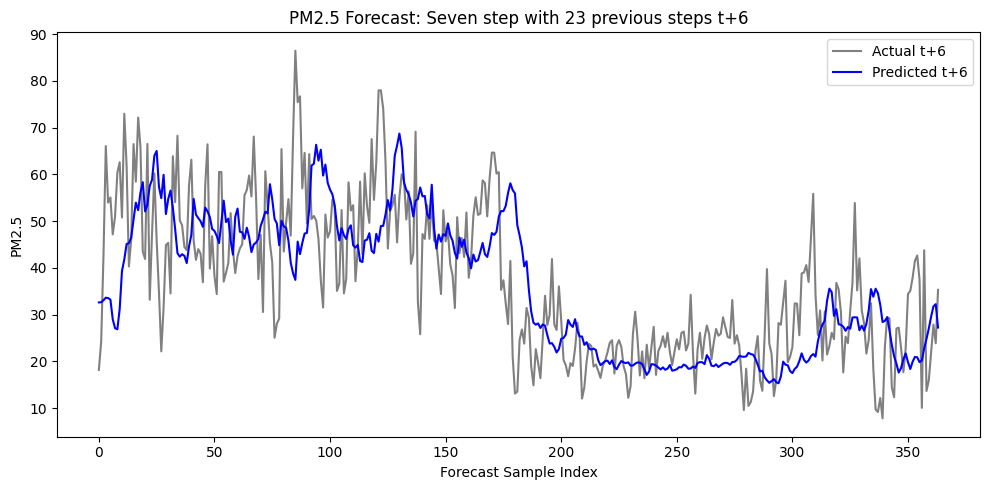

In [ ]:
title = "PM2.5 Forecast: Seven step with 23 previous steps"
titles = [title + f" t+{i}" for i in range(n_steps)]

filename = "seven_step_pred"
filenames = [filename + f"_{i}.png" for i in range(n_steps)]

plot_predicted_actual(inv_yhat_seven, 
                      inv_y_seven, 
                      n_steps, 
                      titles, 
                      filenames, 
                      save=False)

In [32]:
filename = "lstm_seven_step.pkl"
save_model(filename)

NameError: name 'save_model' is not defined

## Reload model

In [ ]:
# Load the model from the file 
# knn_from_joblib = joblib.load('ltsm.pkl') 
  
# Use the loaded model to make predictions 
# knn_from_joblib.predict(test_X) 